# Ranking school examination results using multivariate hierarchical models

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

In [2]:
import json 

with open("data/data.json") as file:
    data = json.load(file)
    
with open("data/init.json") as file:
    init = json.load(file)

In [3]:
for idx, item in data.items():
    data[idx] = np.array(item).reshape(-1)

for idx, item in init.items():
    init[idx] = np.array(item).reshape(-1)
    
data["Omega"] = init["Omega"]
del init["Omega"]

init["T"] = (sp.wishart(scale = data["R"].reshape(3,3), df = 3).rvs() + 1e-6 * np.eye(3)).reshape(-1)

In [5]:
data.keys(), init.keys()

(dict_keys(['Gender', 'LRT', 'M', 'N', 'R', 'school', 'School_denom', 'School_gender', 'Y', 'VR', 'Omega']),
 dict_keys(['theta', 'phi', 'gamma', 'beta', 'alpha', 'T']))

In [48]:
params = dict()
params["tau0"] = 1e-4
params["phi_sd_proposal"] = 1
params["theta_sd_proposal"] = 2
params["T_sd_proposal"] = [2, 2, 2, 2, 2, 2]

In [49]:
def sampler(nchain, data, init, params):
    
    # initialisation de la chaine 
    chain = dict()
    for key, param in init.items():
        chain[key] = np.zeros((nchain+1, param.shape[0]))
        chain[key][0, :] = param
    
    # définition des constantes
    Y = data["Y"]
    
    N = Y.shape[0]
    M = int(data["M"])

    n_beta = 8

    LRT_sum = np.sum(data["LRT"])
    tau0 = params["tau0"]
    phi_sd_proposal = params["phi_sd_proposal"]
    theta_sd_proposal = params["theta_sd_proposal"]
    T_sd_proposal = params["T_sd_proposal"]

    T0 = np.linalg.pinv(data["Omega"].reshape(3, 3))
    R_inv = np.linalg.pinv(data["R"].reshape(3, 3))
    gamma0 = np.random.normal(size=3)
    
    # définition de v
    LRT = data["LRT"]
    Girl = data["Gender"]
    VR = data["VR"].reshape(N, -1, order="F")
    School_gender = data["School_gender"].reshape(N, -1, order="F")
    School_denom = data["School_denom"].reshape(N, -1, order="F")

    v = np.concatenate((
        np.power(LRT, 2).reshape(-1, 1), 
        VR[:, [1]], 
        Girl.reshape(-1, 1), 
        School_gender, 
        School_denom
    ), axis=1)

    # définition de u
    u = np.vstack((np.ones(N), LRT, VR[:, 1])).T
    
    # initialisation de mu 
    mu_current  = np.zeros(N) 
    mu1_current  = np.zeros(N) 
    mu2_current  = np.zeros(N) 
    
    # mise à jour des paramètres
    for i in range(1, nchain+1):
        print(i, end=" ")
        
        # mise à jour de alpha: normale
        ## calcul de tau
        theta_current = chain["theta"][i-1, :]
        phi_current = chain["phi"][i-1, :]
        tau_current = np.exp(theta_current + phi_current * LRT)
        
        ## variables intervenant dans la loi de alpha
        beta_current = chain["beta"][i-1, :]
        mu2_current = np.dot(v, beta_current) 
        mu_current = mu1_current + mu2_current
        
        gamma_current = chain["gamma"][i-1, :]
        T_current = chain["T"][i-1, :].reshape(3, 3)
        
        for j in range(1, M+1):
            school_j = (data["school"] == j)
            tau_j = tau_current[school_j]
            u_j = u[school_j, :]
            v_j = v[school_j, :]
            Y_j = Y[school_j]
            
            n_j = len(Y_j)
            alphaj_cov_inv = T_current
            for k in range(n_j):
                u_kj =  u_j[[k], :]
                alphaj_cov_inv = alphaj_cov_inv + tau_j[k] * np.dot(u_kj.T, u_kj)
            alphaj_cov = np.linalg.pinv(alphaj_cov_inv)
            
            alphaj_mean = np.dot(T_current, gamma_current)
            for k in range(n_j):
                alphaj_mean = alphaj_mean + tau_j[k] * (Y_j[k] - np.dot(beta_current, v_j[k, :])) * u_j[k, :]
            alphaj_mean = np.dot(alphaj_cov, alphaj_mean)
            
            alphaj_proposal = np.random.multivariate_normal(alphaj_mean, alphaj_cov)
            chain["alpha"][i,(3*(j-1)):(3*j)] = alphaj_proposal
        
        alpha_current = chain["alpha"][i, :]
        
        # mise à jour de mu_1 (car elle dépend de alpha)
        for j in range(1, M + 1):
            school_j = (data["school"] == j)
            alpha_j = alpha_current[(3*(j-1)):(3*j)]
            mu1_current[school_j] = np.dot(u[school_j, :], alpha_j) 
        mu_current = mu1_current + mu2_current
        
        # mise à jour de beta: normale multivariée        
        beta_cov_inv = tau0 * np.eye(n_beta) 
        for k in range(N):
            beta_cov_inv = beta_cov_inv + tau_current[k] * np.dot(v[[k], :].T, v[[k], :])
        beta_cov = np.linalg.pinv(beta_cov_inv)
        
        
        tmp = np.zeros(v.shape)
        for k in range(N):
            j = data["school"][k]
            alpha_j = alpha_current[(3*(j-1)):(3*j)]
            tmp_k = tau_current[k] * (Y[k] - np.dot(alpha_j, u[k, :]))
            tmp_k = tmp_k * v[k, :]
            tmp[k, :] = tmp_k
        beta_mean = np.sum(tmp, axis=0)
        beta_mean = np.dot(beta_cov, beta_mean)
        
        beta_proposal = np.random.multivariate_normal(beta_mean, beta_cov)
        
        chain["beta"][i, :] = beta_proposal
        beta_current = beta_proposal
        mu2_current = np.dot(v, beta_current)
        mu_current = mu1_current + mu2_current
        
        # mise à jour de phi: mcmc 
        # phi peut prendre toutes les valeurs réelles, 
        # donc on utilise le "random walk M.-H. scheme"
        phi_proposal = phi_current + np.random.normal(scale=phi_sd_proposal)
        
        phi_top = - tau0 * np.power(phi_proposal, 2)
        phi_top += LRT_sum * phi_proposal
        phi_top -= np.exp(theta_current) * np.sum(
            np.exp(phi_proposal*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
        )
        phi_top *= .5
        
        phi_bottom = -tau0 * np.power(phi_current, 2)
        phi_bottom += LRT_sum * phi_current
        phi_bottom -= np.exp(theta_current) * np.sum(
            np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu_current, 2)
        )
        phi_bottom *= .5
        
        phi_acceptance = np.exp(phi_top-phi_bottom)
        if phi_acceptance > np.random.rand():
            chain["phi"][i,:] = phi_proposal
            phi_current = phi_proposal
            tau_current = np.exp(theta_current + phi_current * LRT)
        else:
            chain["phi"][i,:] = phi_current

        
        # mise à jour de theta: mcmc 
        # theta peut prendre toutes les valeurs réelles, 
        # donc on utilise le "random walk M.-H. scheme"        
        theta_proposal = theta_current + np.random.normal(scale=theta_sd_proposal)
        
        theta_sum = np.sum(np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu_current, 2))
        
        theta_top = -tau0 * np.power(theta_proposal, 2)
        theta_top += N * theta_proposal
        theta_top -= np.exp(theta_proposal) * theta_sum
        theta_top *= .5
        
        theta_bottom = -tau0 * np.power(theta_current, 2)
        theta_bottom += N * theta_current
        theta_bottom -= np.exp(theta_current) * theta_sum
        theta_bottom *= .5
        
        theta_acceptance = np.exp(theta_top-theta_bottom)
        if theta_acceptance > np.random.rand():
            chain["theta"][i,:] = theta_proposal
            theta_current = theta_proposal
            tau_current = np.exp(theta_current + phi_current * LRT)
        else:
            chain["theta"][i,:] = theta_current
        
        # mise à jour de gamma: normale
        alpha_current_sum = np.zeros(3)
        for j in range(1, M+1):
            alpha_current_sum = alpha_current_sum + alpha_current[(3*(j-1)):(3*j)]
        
        gamma_cov = np.linalg.pinv(T0 + M*T_current)
        gamma_mean = np.dot(gamma_cov, np.dot(T0, gamma0) + np.dot(T_current, alpha_current_sum))
        
        gamma_proposal = np.random.multivariate_normal(gamma_mean, gamma_cov)
        
        chain["gamma"][i, :] = gamma_proposal
        gamma_current = gamma_proposal
        
        # mise à jour de T: mcmc       
        for k, (a, b) in enumerate(((0,0), (0,1), (0,2), (1,1), (1,2), (2,2))):
            # boucle pour garantir que T reste définie positive
            while True:
                Tab = np.random.normal(T_current[a, b], scale=T_sd_proposal[k])
                T_proposal = np.copy(T_current)
         
                T_proposal[a, b] = Tab
                T_proposal[b, a] = Tab
                
                if np.all(np.linalg.eigvals(T_proposal) > 0):
                    break
            
            T_top = (M-1) * np.log(np.linalg.det(T_proposal))
            T_top -= np.sum(np.diag(np.dot(R_inv, T_proposal))) 
            
            T_bottom = (M-1) * np.log(np.linalg.det(T_current))
            T_bottom -= np.sum(np.diag(np.dot(R_inv, T_current))) 
            for j in range(1, M+1):
                alpha_j = alpha_current[(3*(j-1)):(3*j)]
                diff_j = (gamma_current - alpha_j).reshape(-1, 1)
                T_top -= np.dot(diff_j.T, np.dot(T_proposal, diff_j))
                T_bottom -= np.dot(diff_j.T, np.dot(T_current, diff_j))
            T_top *= .5
            T_bottom *= .5
            
            T_acceptance = np.exp(T_top - T_bottom)
            
            if T_acceptance > np.random.rand():
                chain["T"][i, :] = T_proposal.flatten()
                T_current = T_proposal
            else:
                chain["T"][i, :] = T_current.flatten()
            
    return(chain)     

In [50]:
 chain = sampler(100, data, init, params)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

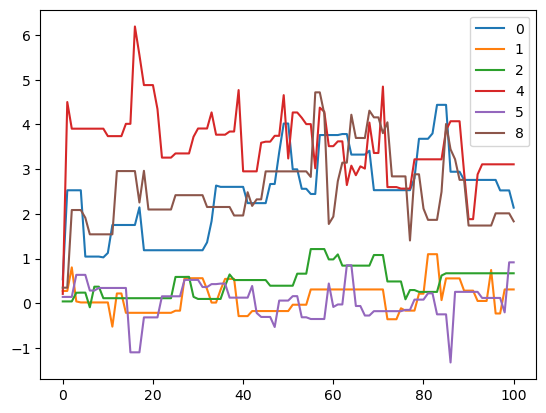

In [51]:
fig, ax = plt.subplots()
for i in (0, 1, 2, 4, 5, 8):
    ax.plot(chain["T"][:, i], label=i)
plt.legend()

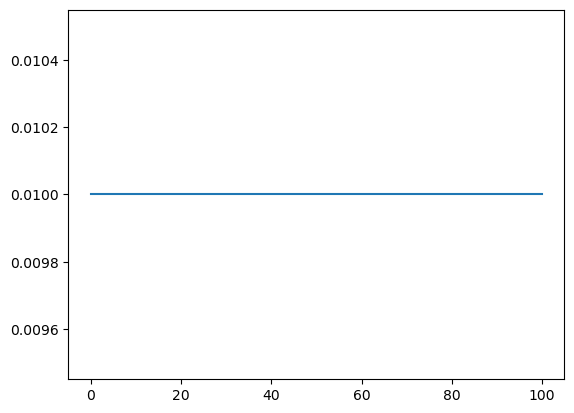

In [52]:
plt.plot(chain["phi"])